In [1]:
%pip install segmentation-models-pytorch
%pip install torch torchvision

In [2]:
import os
import numpy as np
from PIL import Image
from torch.utils.data import Dataset

class SegmentationDataset(Dataset):
    def __init__(self, image_dir, masks, transform=None):
        self.image_dir = image_dir
        self.masks = masks  # Expecting mask arrays instead of image directory
        self.transform = transform
        # Assuming images still come from a directory
        self.images = [f for f in os.listdir(image_dir) if f.endswith('.png')]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.images[idx])
        image = Image.open(img_path).convert("RGB")
        mask = self.masks[idx]  # Get the mask directly from the array
        image = np.array(image)
        mask = np.array(mask)
        
        if self.transform:
            augmentations = self.transform(image=image, mask=mask)
            image = augmentations["image"]
            mask = augmentations["mask"]
        
        return image, mask

In [3]:
from albumentations import Compose, Resize, Normalize, HorizontalFlip
from albumentations.pytorch import ToTensorV2

transform = Compose([
    Resize(256, 256),
    Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

In [4]:
# Libraries to process the masks

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
import cv2

from PIL import Image

In [5]:
images_df = pd.read_csv('train.csv')
print('Shape of images_df: ', images_df.shape)

Shape of images_df:  (73585, 9)


In [6]:
images_df.dtypes

id                   object
annotation           object
width                 int64
height                int64
cell_type            object
plate_time           object
sample_date          object
sample_id            object
elapsed_timedelta    object
dtype: object

In [7]:
images_df.head()

,id,annotation,width,height,cell_type,plate_time,sample_date,sample_id,elapsed_timedelta
0,0030fd0e6378,118145 6 118849 7 119553 8 120257 8 120961 9 1...,704,520,shsy5y,11h30m00s,6/16/19,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
1,0030fd0e6378,189036 1 189739 3 190441 6 191144 7 191848 8 1...,704,520,shsy5y,11h30m00s,6/16/19,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
2,0030fd0e6378,173567 3 174270 5 174974 5 175678 6 176382 7 1...,704,520,shsy5y,11h30m00s,6/16/19,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
3,0030fd0e6378,196723 4 197427 6 198130 7 198834 8 199538 8 2...,704,520,shsy5y,11h30m00s,6/16/19,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
4,0030fd0e6378,167818 3 168522 5 169225 7 169928 8 170632 9 1...,704,520,shsy5y,11h30m00s,6/16/19,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00


In [8]:
unique_img_ids = images_df['id'].unique()

In [9]:
print('Unique Image ID count: ', len(unique_img_ids))

Unique Image ID count:  606


In [10]:
sample_filename = '0030fd0e6378'
sample_image_df = images_df[images_df['id'] == sample_filename]
print(sample_image_df['id'].iloc[0])

0030fd0e6378


In [11]:
sample_image_df['annotation'].values

array(['118145 6 118849 7 119553 8 120257 8 120961 9 121665 10 122369 12 123074 13 123778 14 124482 15 125186 16 125890 17 126594 18 127298 19 128002 20 128706 21 129410 22 130114 23 130818 24 131523 24 132227 25 132931 25 133635 24 134339 24 135043 23 135748 21 136452 19 137157 16 137864 11 138573 4',
       '189036 1 189739 3 190441 6 191144 7 191848 8 192552 9 193256 10 193960 11 194664 11 195368 12 196072 12 196776 13 197480 13 198185 13 198889 13 199593 14 200297 13 201002 11 201706 10 202410 9 203115 7 203819 6 204523 5 205227 5 205932 3 206636 2 207340 1',
       '173567 3 174270 5 174974 5 175678 6 176382 7 177085 9 177789 9 178493 10 179197 11 179901 12 180605 12 181308 14 182012 15 182716 15 183420 16 184125 16 184831 15 185536 14 186241 14 186947 12 187651 13 188356 12 189061 12 189767 10 190472 10 191177 9 191883 7 192589 5 193295 2 194000 1',
       '196723 4 197427 6 198130 7 198834 8 199538 8 200242 9 200946 9 201650 10 202354 10 203058 10 203762 11 204466 11 205170 12 2

In [12]:
sample_path = f"train/{sample_image_df['id'].iloc[0]}.png"
sample_img = cv2.imread(sample_path)
sample_rles = sample_image_df['annotation'].values

In [13]:
sample_img.shape

(520, 704, 3)

In [14]:
def rle_decode(mask_rle, shape, color=1):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros((shape[0] * shape[1], shape[2]), dtype=np.float32)
    for lo, hi in zip(starts, ends):
        img[lo : hi] = color
    return img.reshape(shape)


def build_masks(labels,input_shape, colors=True):
    height, width = input_shape
    if colors:
        mask = np.zeros((height, width, 3))
        for label in labels:
            mask += rle_decode(label, shape=(height,width , 3), color=np.random.rand(3))
    else:
        mask = np.zeros((height, width, 1))
        for label in labels:
            mask += rle_decode(label, shape=(height, width, 1))
    mask = mask.clip(0, 1)
    return mask

(-0.5, 703.5, 519.5, -0.5)

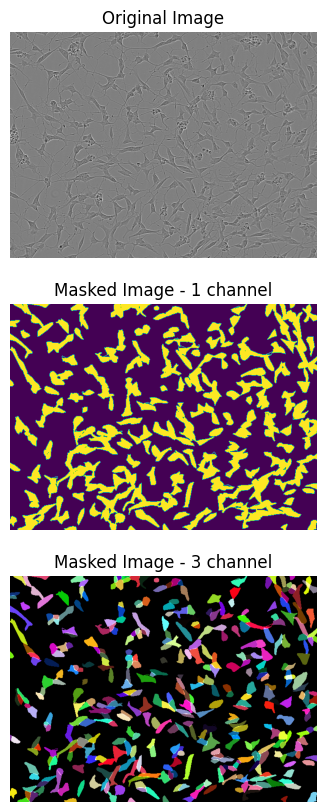

In [15]:
sample_masks1=build_masks(sample_rles,input_shape=(520, 704), colors=False)
sample_masks2=build_masks(sample_rles,input_shape=(520, 704), colors=True)

fig, axs = plt.subplots(3, figsize=(10, 10))
axs[0].imshow(sample_img)
axs[0].set_title('Original Image')
axs[0].axis('off')

axs[1].imshow(sample_masks1)
axs[1].set_title('Masked Image - 1 channel')
axs[1].axis('off')

axs[2].imshow(sample_masks2)
axs[2].set_title('Masked Image - 3 channel')
axs[2].axis('off')

In [16]:
# Save masked images as numpy array

mask_arrays = []

# Function that generates annotations for all images
def generate_annotations(images_df):    
    
    # Iterates every unique image ID in the folder
    for file_name in images_df['id'].unique():
        
        img_df = images_df[images_df['id'] == file_name]

        img_path = f"train/{img_df['id'].iloc[0]}.png"
        img = cv2.imread(img_path)
        img_rles = img_df['annotation'].values
        
        img_annotation = build_masks(img_rles,input_shape=(520, 704), colors=False)
        
        # Add mask to array
        mask_arrays.append(img_annotation)

In [17]:
%%time
generate_annotations(images_df)

[ WARN:0@5.660] global /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_562_cazh1h/croots/recipe/opencv-suite_1664548333142/work/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('train/1.74794E+11.png'): can't open/read file: check file path/integrity
[ WARN:0@13.244] global /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_562_cazh1h/croots/recipe/opencv-suite_1664548333142/work/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('train/5.17649E+11.png'): can't open/read file: check file path/integrity
[ WARN:0@16.571] global /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_562_cazh1h/croots/recipe/opencv-suite_1664548333142/work/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('train/7.24098E+11.png'): can't open/read file: check file path/integrity
[ WARN:0@21.337] global /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_562_cazh1h/croots/recipe/opencv-suite_1664548333142/work/modules/imgcodecs/src/loadsa

CPU times: user 30.6 s, sys: 447 ms, total: 31 s
Wall time: 31.8 s


### Preparing training and validation folders

In [18]:
import os
import shutil

# Source and destination directories
source_dir = 'train'
train_dir = 'train_imgs'
valid_dir = 'validation_imgs'

# Ensure the destination directory exists
os.makedirs(train_dir, exist_ok=True)
os.makedirs(valid_dir, exist_ok=True)

# Copy files from original into train and test

print('*** Copying to Training folder ***')
for file_name in unique_img_ids[:10]:
    source_path = os.path.join(source_dir, file_name + '.png')
    destination_path = os.path.join(train_dir, file_name + '.png')
    
    # Check if the file exists in the source directory
    if os.path.exists(source_path):
        shutil.copy(source_path, destination_path)
        print(f"Copied: {file_name}")
    else:
        print(f"File not found: {file_name}")

print('*** Copying to Validation folder ***')        
for file_name in unique_img_ids[10:15]:
    source_path = os.path.join(source_dir, file_name + '.png')
    destination_path = os.path.join(valid_dir, file_name + '.png')
    
    # Check if the file exists in the source directory
    if os.path.exists(source_path):
        shutil.copy(source_path, destination_path)
        print(f"Copied: {file_name}")
    else:
        print(f"File not found: {file_name}")       

*** Copying to Training folder ***
Copied: 0030fd0e6378
Copied: 0140b3c8f445
Copied: 01ae5a43a2ab
Copied: 026b3c2c4b32
Copied: 029e5b3b89c7
Copied: 0323e81d23d9
Copied: 03b27b381a5f
Copied: 042c17cd9143
Copied: 042dc0e561a4
Copied: 04928f0866b0
*** Copying to Validation folder ***
Copied: 049f02e0f764
Copied: 04cd81dfb245
Copied: 053d61766edb
Copied: 05c61f0f46b7
Copied: 061b49d7dbbb


In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import segmentation_models_pytorch as smp
import numpy as np
from PIL import Image
import os

In [20]:
# Example mask arrays (replace with your actual mask arrays)

train_masks = mask_arrays[:25]
val_masks = mask_arrays[25:35]

train_dataset = SegmentationDataset(image_dir="train_imgs/", 
                                    masks=train_masks, 
                                    transform=transform)

val_dataset = SegmentationDataset(image_dir="validation_imgs/", 
                                  masks=val_masks, 
                                  transform=transform)

In [21]:
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

In [22]:
for batch in train_loader:
    print(batch)

[tensor([[[[-0.0629, -0.0287,  0.0398,  ...,  0.0398, -0.1657,  0.5193],
          [ 0.2967,  0.2624, -0.1143,  ...,  0.2967,  0.1083,  0.4679],
          [-0.1999,  0.0398,  0.2453,  ...,  0.1597,  0.1254, -0.4568],
          ...,
          [ 0.0912,  0.0741,  0.0227,  ...,  0.1083,  0.0741,  0.0741],
          [ 0.0912,  0.1083, -0.0116,  ...,  0.0398,  0.1083,  0.0569],
          [ 0.0398,  0.1083,  0.0569,  ...,  0.0741,  0.1426,  0.2453]],

         [[ 0.0651,  0.1001,  0.1702,  ...,  0.1702, -0.0399,  0.6604],
          [ 0.4328,  0.3978,  0.0126,  ...,  0.4328,  0.2402,  0.6078],
          [-0.0749,  0.1702,  0.3803,  ...,  0.2927,  0.2577, -0.3375],
          ...,
          [ 0.2227,  0.2052,  0.1527,  ...,  0.2402,  0.2052,  0.2052],
          [ 0.2227,  0.2402,  0.1176,  ...,  0.1702,  0.2402,  0.1877],
          [ 0.1702,  0.2402,  0.1877,  ...,  0.2052,  0.2752,  0.3803]],

         [[ 0.2871,  0.3219,  0.3916,  ...,  0.3916,  0.1825,  0.8797],
          [ 0.6531,  0.6182, 

In [23]:
model = smp.Unet(
                encoder_name="resnet34",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
                encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
                in_channels=3,                  # model input channels (1 for grayscale images, 3 for RGB, etc.)
                classes=1,                      # model output channels (number of classes in your dataset)
                )

In [24]:
loss_fn = smp.losses.DiceLoss(mode='binary')
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [25]:
for b in val_loader:
    print(b)

[tensor([[[[ 0.0398, -0.1828,  0.2282,  ...,  0.0741,  0.0741,  0.0569],
          [ 0.0056, -0.0116,  0.0912,  ...,  0.0912,  0.0398,  0.0569],
          [-0.0972,  0.0912,  0.0912,  ...,  0.0741,  0.0569,  0.0741],
          ...,
          [ 0.0912,  0.5193, -0.1657,  ..., -0.0287,  0.0569,  0.0741],
          [ 0.6392, -0.2342, -0.7650,  ...,  0.4166, -0.2684, -0.0629],
          [ 0.7933, -0.5424, -1.0562,  ...,  0.5193, -0.2513,  0.2111]],

         [[ 0.1702, -0.0574,  0.3627,  ...,  0.2052,  0.2052,  0.1877],
          [ 0.1352,  0.1176,  0.2227,  ...,  0.2227,  0.1702,  0.1877],
          [ 0.0301,  0.2227,  0.2227,  ...,  0.2052,  0.1877,  0.2052],
          ...,
          [ 0.2227,  0.6604, -0.0399,  ...,  0.1001,  0.1877,  0.2052],
          [ 0.7829, -0.1099, -0.6527,  ...,  0.5553, -0.1450,  0.0651],
          [ 0.9405, -0.4251, -0.9503,  ...,  0.6604, -0.1275,  0.3452]],

         [[ 0.3916,  0.1651,  0.5834,  ...,  0.4265,  0.4265,  0.4091],
          [ 0.3568,  0.3393, 

In [26]:
num_epochs = 40
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for images, masks in train_loader:
#         images = images #.to(device)
#         masks = masks  # Use float32

        optimizer.zero_grad()
        outputs = model(images)
        
        # Apply sigmoid if needed
        outputs = torch.sigmoid(outputs)
        
        # Calculate loss
        loss = loss_fn(outputs, masks)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    val_loss = 0
    model.eval()
    with torch.no_grad():
        for images, masks in val_loader:
            images = images.to(device)
            masks = masks.to(dtype=torch.float32).to(device)  # Ensure masks are float32
            
            outputs = model(images)
            outputs = torch.sigmoid(outputs)  # Apply sigmoid if needed
            
            loss = loss_fn(outputs, masks)
            val_loss += loss.item()
    
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss/len(train_loader)}, Val Loss: {val_loss/len(val_loader)}")

Epoch 1/40, Train Loss: 0.853968063990275, Val Loss: 0.8979704678058624
Epoch 2/40, Train Loss: 0.8483883341153463, Val Loss: 0.8966411054134369
Epoch 3/40, Train Loss: 0.8120177388191223, Val Loss: 0.895931601524353
Epoch 4/40, Train Loss: 0.8120684623718262, Val Loss: 0.8961884379386902
Epoch 5/40, Train Loss: 0.8094329833984375, Val Loss: 0.894102543592453
Epoch 6/40, Train Loss: 0.8142849802970886, Val Loss: 0.891423374414444
Epoch 7/40, Train Loss: 0.7952528794606527, Val Loss: 0.8939970135688782
Epoch 8/40, Train Loss: 0.7947298288345337, Val Loss: 0.8936019241809845
Epoch 9/40, Train Loss: 0.8026702205340067, Val Loss: 0.9004140794277191
Epoch 10/40, Train Loss: 0.8147595922152201, Val Loss: 0.9009060263633728
Epoch 11/40, Train Loss: 0.7925679087638855, Val Loss: 0.8958976566791534
Epoch 12/40, Train Loss: 0.8418546915054321, Val Loss: 0.8912188112735748
Epoch 13/40, Train Loss: 0.7921841939290365, Val Loss: 0.8940791189670563
Epoch 14/40, Train Loss: 0.7998383045196533, Val Lo

In [27]:
outputs

tensor([[[[0.1452, 0.0485, 0.0499,  ..., 0.0259, 0.0268, 0.0522],
          [0.0763, 0.0129, 0.0151,  ..., 0.0052, 0.0056, 0.0171],
          [0.0889, 0.0158, 0.0135,  ..., 0.0051, 0.0068, 0.0193],
          ...,
          [0.0759, 0.0111, 0.0074,  ..., 0.4785, 0.2633, 0.1946],
          [0.0869, 0.0137, 0.0098,  ..., 0.3119, 0.1854, 0.1558],
          [0.2181, 0.0633, 0.0516,  ..., 0.3062, 0.2376, 0.2433]]]])

In [28]:
# Visualization
def visualize_predictions(model, dataloader, device):
    model.eval()
    with torch.no_grad():
        for i, (images, masks) in enumerate(dataloader):
            if i == 3:  # Display only the first 3 images
                break
            images = images.to(device)
            outputs = model(images)
            preds = torch.sigmoid(outputs).cpu().numpy()
            images = images.cpu().numpy().transpose(0, 2, 3, 1)
            masks = masks.cpu().numpy()

            fig, axs = plt.subplots(1, 3, figsize=(15, 5))
            axs[0].imshow(images[0])
            axs[0].set_title('Original Image')
            axs[0].axis('off')

            axs[1].imshow(masks[0])
            axs[1].set_title('Ground Truth Mask')
            axs[1].axis('off')

            axs[2].imshow(preds[0, 0]) # , cmap='gray'
            axs[2].set_title('Predicted Mask')
            axs[2].axis('off')

            plt.tight_layout()
            plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


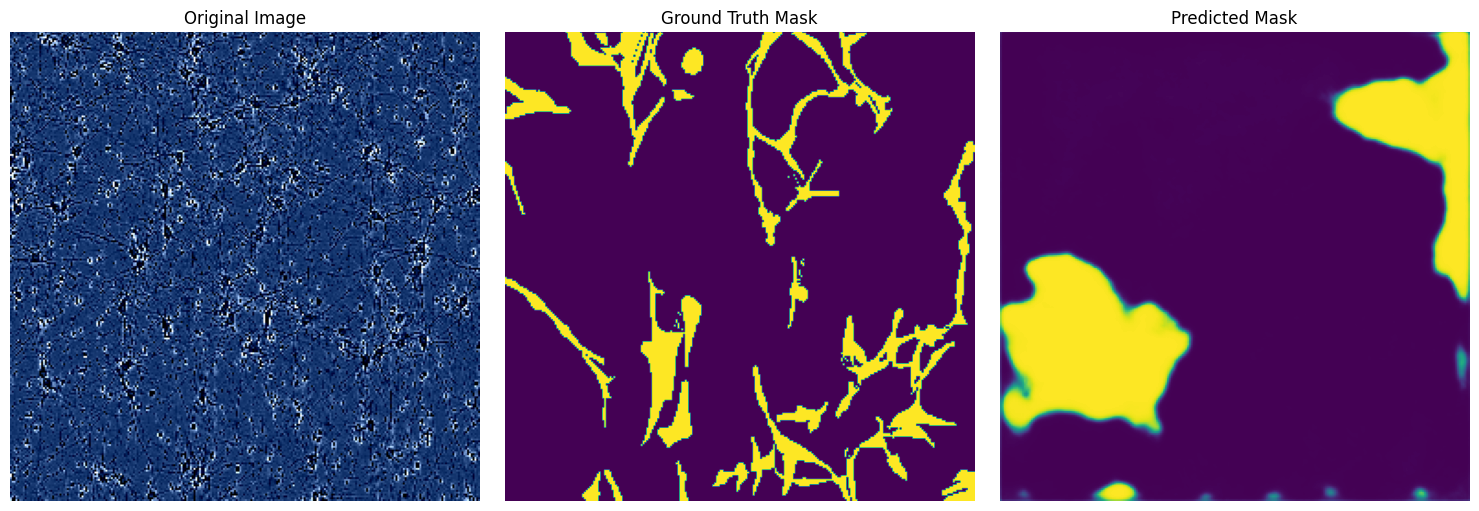

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


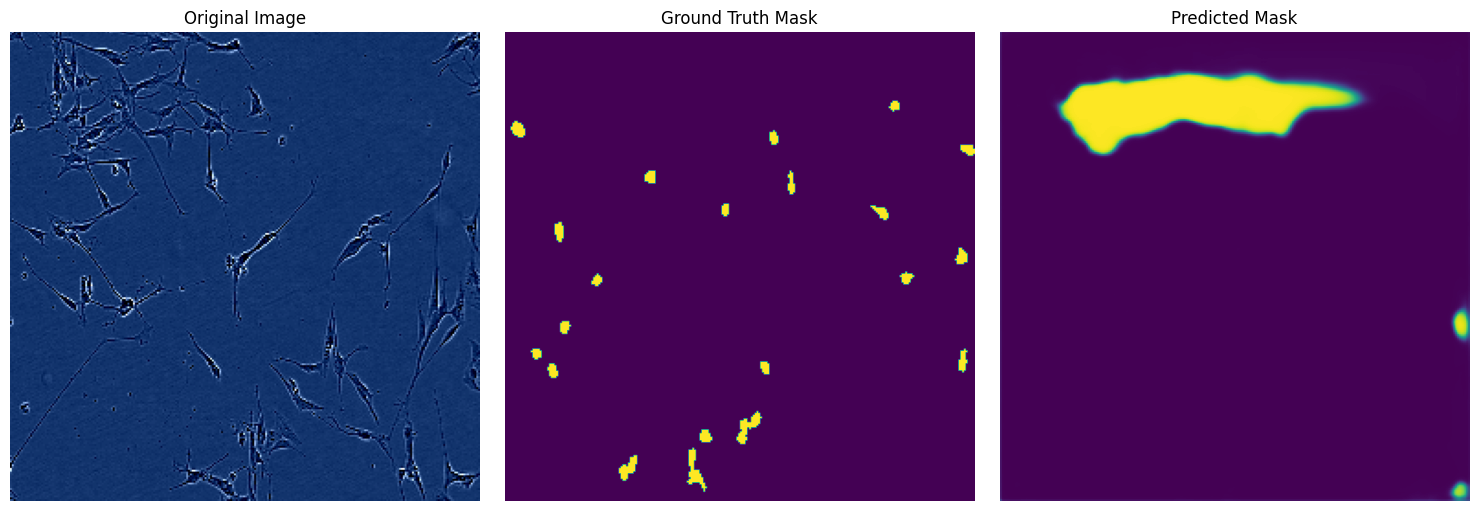

In [29]:
# Call the visualization function
visualize_predictions(model, val_loader, device)